<a href="https://colab.research.google.com/github/woaixuexi2023/D2L--Module2--HW1/blob/main/D2L_Module4_Hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**AutoEncoder**

In [1]:
#Import Packages
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import torch; 
#Sets the seed for generating random numbers.
torch.manual_seed(0)

#torch. nn import gives us access to some helpful neural network things, such as various neural network layer types (things like regular fully-connected layers, convolutional layers (for imagery), recurrent layers...etc).
import torch.nn as nn 

#applies Convolution functions
import torch.nn.functional as F

#allow to access pre-loaded datasets as well as your own data
import torch.utils

#contains parameterizable probability distributions and sampling functions
import torch.distributions

#consists of popular datasets, model architectures, and common image transformations for computer vision
import torchvision

import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

In [3]:
#Encoder class
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [4]:
#Decoder class
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [5]:
#Cobine the encoder and decoder  into Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


In [6]:
#Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
#Define latent_dims
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device)#GPU

In [30]:
#Train model
#def train(autoencoder, data, epochs=20):
#    opt = torch.optim.Adam(autoencoder.parameters())
#    for epoch in range(epochs):
#        for x, y in data:
#            x = x.to(device) # GPU
#            opt.zero_grad()
#            x_hat = autoencoder(x)
#            loss = ((x - x_hat)**2).mean() #the loss function is sum of the square error----Change it to MSE????
#            loss.backward()
#            opt.step()
#    return autoencoder

In [ ]:
#Load MNIST Data
data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

#transform the image data into tensor
train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

#or do the following
#from torchvision.datasets import MNIST
#from torchvision.transforms import ToTensor

# Load the MNIST dataset
#train_data = MNIST(root='data/', train=True, transform=ToTensor(), download=True)
#train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

In [9]:
len(train_dataset)
#len(train_dataset)-len(train_dataset)*0.2

60000

In [11]:
#Split the data set
#m=len(train_dataset)

#train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)]) #random split the dataset into 48000(80%) and 12000(20%)
batch_size=128

#creat data loader for train/val/test which are split to mini_batches
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
#valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

#It is used when working with large datasets that cannot fit into memory,or to perform batch processing of the data.
#dataloader() can easliy shuffer the dataset
#

In [ ]:
#Define imgshow() to show the images                         ????how to show 10 images?????????????
classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

def imshow(img):
     img = img / 2 + 0.5
     npimg = img.numpy()
     plt.imshow(np.transpose(npimg, (1, 2, 0)))
     plt.show()
    
dataiter = iter(test_dataset)
images, labels = next(dataiter)   

imshow(torchvision.utils.make_grid(images[0:10]))

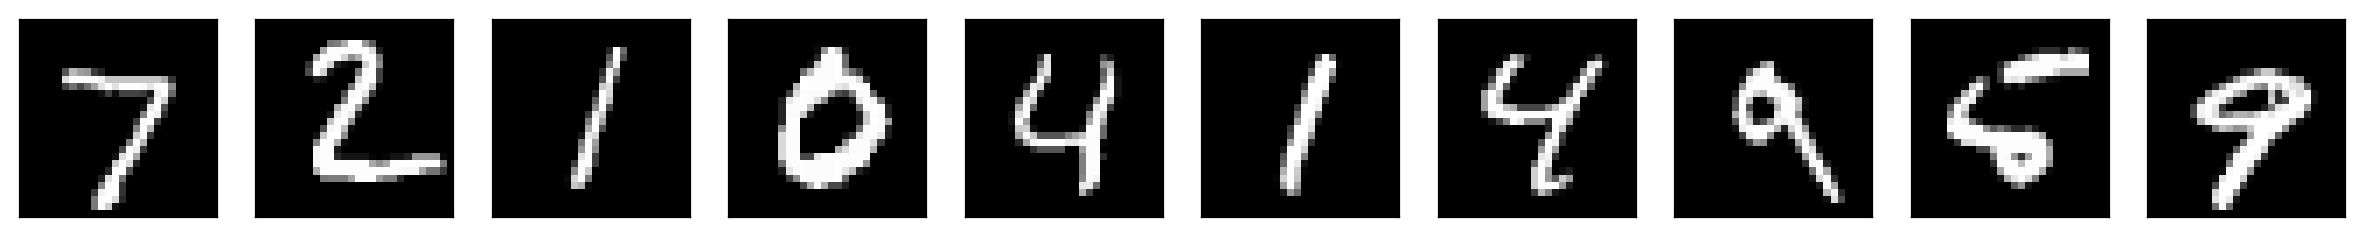

In [19]:
#Choose the first 10 images to display
images10 = torch.stack([test_dataset[i][0] for i in range(0,10)])

#Visulize the 10 images
fig, axs = plt.subplots(1, 10, figsize=(15, 5))
for i in range(10):
    axs[i].imshow(images10[i].squeeze(), cmap='gray')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()


In [12]:
#The train model that can track the loss and update
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    train_losses = [] #to store the training loss for each epoch
    for epoch in range(epochs):
        train_loss = 0.0
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).mean()
            loss.backward()
            opt.step()
            train_loss += loss.item() * x.size(0)
        train_loss /= len(data.dataset)
        train_losses.append(train_loss)#append the training loss for this epoch
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}')
    return autoencoder

In [58]:
#train the train_data
autoencoder_train = train(autoencoder, train_loader)

Epoch [1/20], Loss: 0.0375
Epoch [2/20], Loss: 0.0375
Epoch [3/20], Loss: 0.0374
Epoch [4/20], Loss: 0.0374
Epoch [5/20], Loss: 0.0373
Epoch [6/20], Loss: 0.0373
Epoch [7/20], Loss: 0.0373
Epoch [8/20], Loss: 0.0372
Epoch [9/20], Loss: 0.0372
Epoch [10/20], Loss: 0.0372
Epoch [11/20], Loss: 0.0372
Epoch [12/20], Loss: 0.0372
Epoch [13/20], Loss: 0.0371
Epoch [14/20], Loss: 0.0371
Epoch [15/20], Loss: 0.0371
Epoch [16/20], Loss: 0.0371
Epoch [17/20], Loss: 0.0370
Epoch [18/20], Loss: 0.0370
Epoch [19/20], Loss: 0.0370
Epoch [20/20], Loss: 0.0370


In [46]:
#train the test_data
autoencoder_test = train(autoencoder, test_loader)

Epoch [1/20], Train Loss: 0.0390
Epoch [2/20], Train Loss: 0.0382
Epoch [3/20], Train Loss: 0.0378
Epoch [4/20], Train Loss: 0.0377
Epoch [5/20], Train Loss: 0.0375
Epoch [6/20], Train Loss: 0.0373
Epoch [7/20], Train Loss: 0.0372
Epoch [8/20], Train Loss: 0.0371
Epoch [9/20], Train Loss: 0.0370
Epoch [10/20], Train Loss: 0.0369
Epoch [11/20], Train Loss: 0.0369
Epoch [12/20], Train Loss: 0.0368
Epoch [13/20], Train Loss: 0.0368
Epoch [14/20], Train Loss: 0.0367
Epoch [15/20], Train Loss: 0.0367
Epoch [16/20], Train Loss: 0.0366
Epoch [17/20], Train Loss: 0.0365
Epoch [18/20], Train Loss: 0.0365
Epoch [19/20], Train Loss: 0.0364
Epoch [20/20], Train Loss: 0.0364


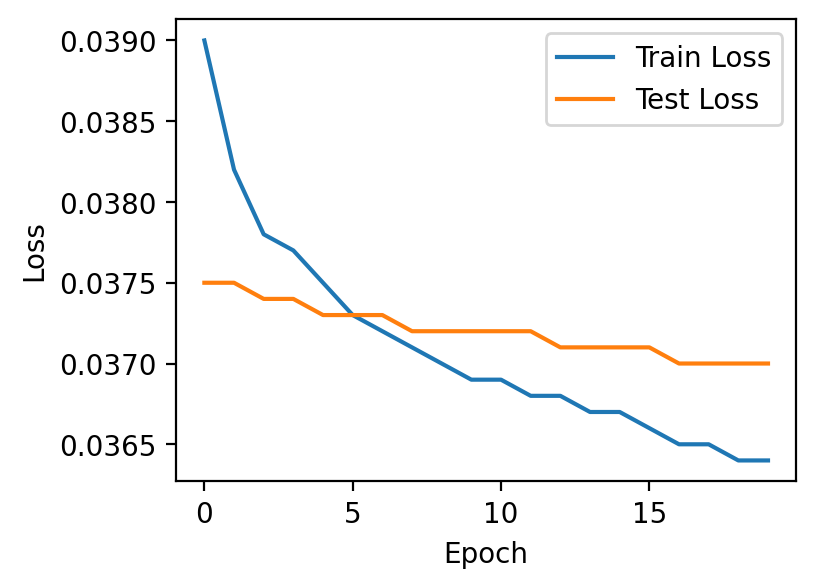

In [67]:
#Graph the train loss and test loss

def plot_loss(train_loss, test_loss):
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.plot(train_loss, label='Train Loss')
    ax.plot(test_loss, label='Test Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.show()

train_loss = [0.0390, 0.0382, 0.0378, 0.0377, 0.0375, 0.0373, 0.0372, 0.0371, 0.0370, 0.0369, 
              0.0369, 0.0368, 0.0368, 0.0367, 0.0367, 0.0366, 0.0365, 0.0365, 0.0364, 0.0364]
test_loss = [0.0375, 0.0375, 0.0374, 0.0374, 0.0373, 0.0373, 0.0373, 0.0372, 0.0372, 0.0372, 
             0.0372, 0.0372, 0.0371, 0.0371, 0.0371, 0.0371, 0.0370, 0.0370, 0.0370, 0.0370]

plot_loss(train_loss, test_loss)


In [20]:
# Random select 10 images from the test dataset
indices = random.sample(range(len(test_dataset)), 10)
images = torch.stack([test_dataset[i][0] for i in indices])

print("Selected image indices:", indices)

Selected image indices: [9670, 9214, 3931, 4519, 2189, 6180, 6211, 7240, 4500, 3004]


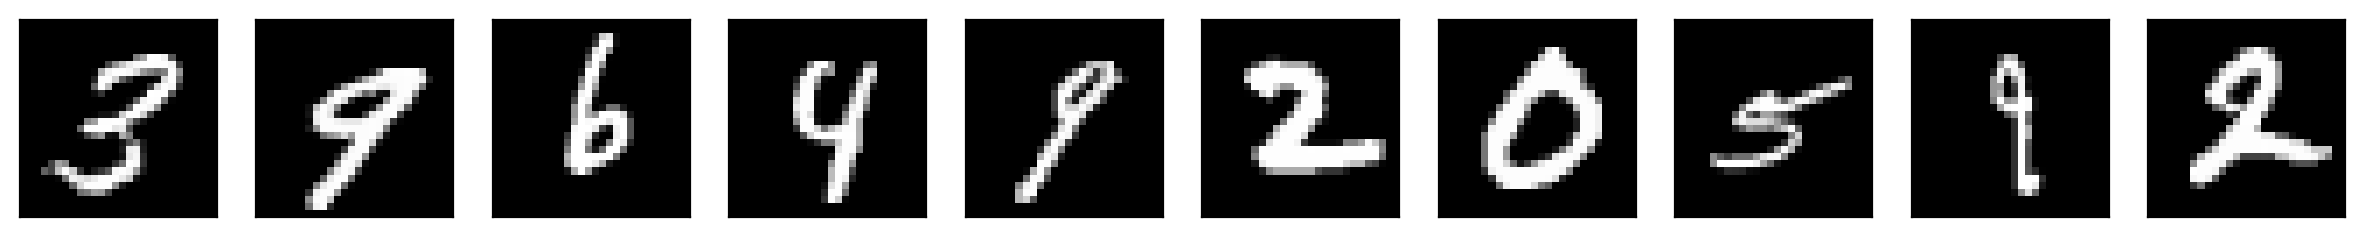

In [21]:
#Visulize the 10 images
fig, axs = plt.subplots(1, 10, figsize=(15, 5))
for i in range(10):
    axs[i].imshow(images[i].squeeze(), cmap='gray')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()


In [23]:
#load the 10 images
data_loader = torch.utils.data.DataLoader(images, batch_size=2, shuffle=True)

# Define training parameters
num_epochs = 10
batch_size = 2
learning_rate = 0.001

# Define model, loss function, and optimizer
model = Autoencoder(latent_dims=2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# Train the model
for epoch in range(num_epochs):
    for data in data_loader:
        img = data
        # Forward pass
        output = model(img)
        loss = criterion(output, img)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

print('Training completed!')


Epoch [1/10], Loss: 0.1655
Epoch [2/10], Loss: 0.0710
Epoch [3/10], Loss: 0.0534
Epoch [4/10], Loss: 0.0530
Epoch [5/10], Loss: 0.0741
Epoch [6/10], Loss: 0.0877
Epoch [7/10], Loss: 0.0604
Epoch [8/10], Loss: 0.0854
Epoch [9/10], Loss: 0.0536
Epoch [10/10], Loss: 0.0644
Training completed!


Pass the original 10 images through the trained Autoencoder model and display the output along with the original images

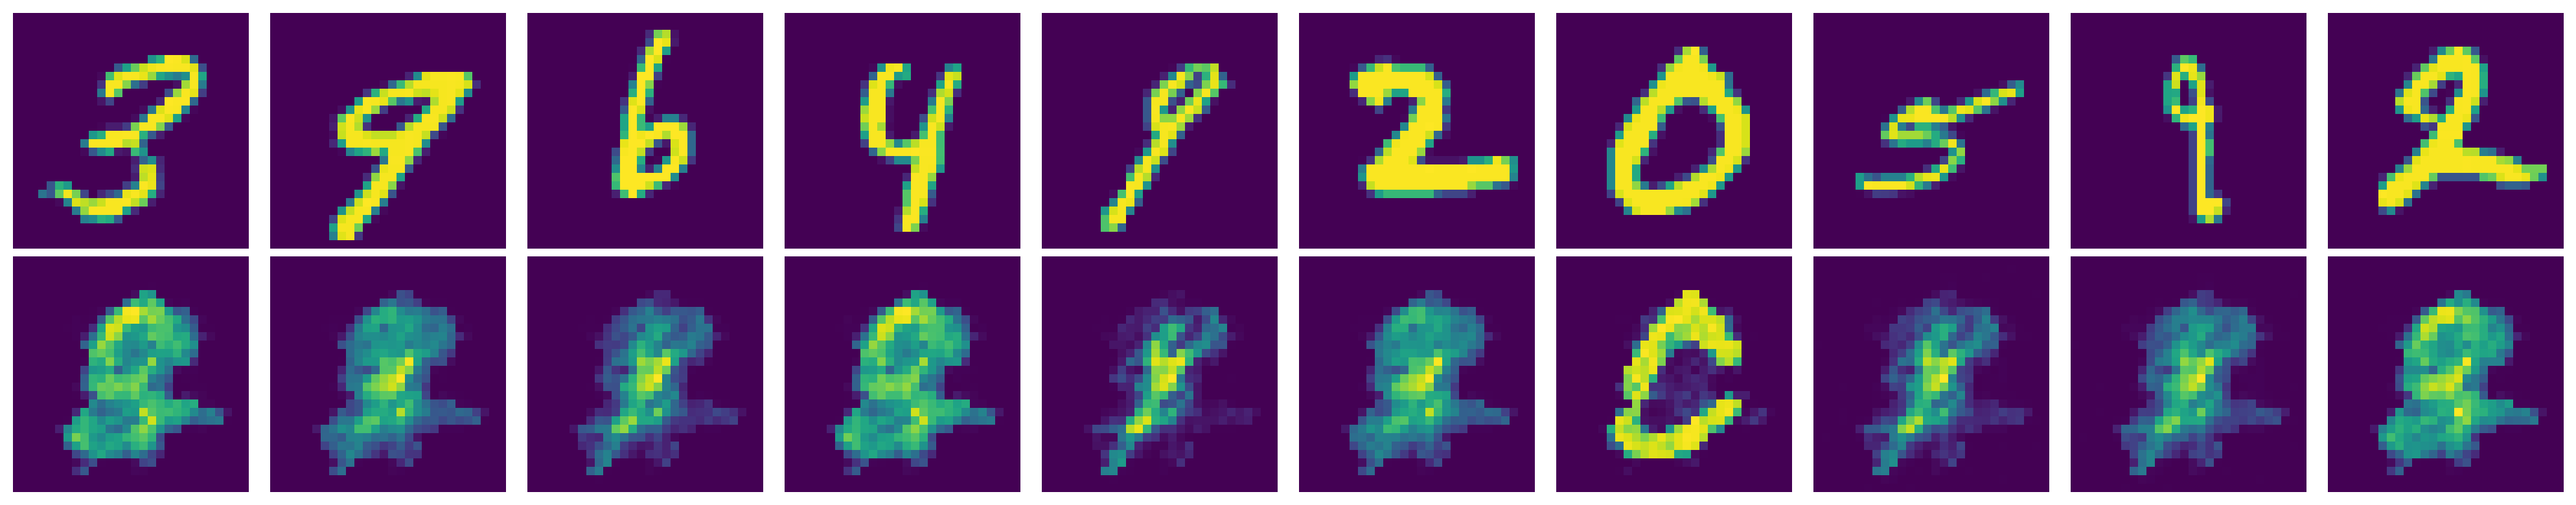

In [24]:
# Display original and decoded images
with torch.no_grad():
    decoded_imgs = model(images).detach().numpy()

n = len(images)
fig, ax = plt.subplots(2, n, figsize=(n*2, 4))

for i in range(n):
    # display original images
    ax[0][i].imshow(images[i].permute(1, 2, 0))
    ax[0][i].axis('off')
    
    # display reconstructed images
    ax[1][i].imshow(decoded_imgs[i].transpose(1, 2, 0))
    ax[1][i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#If Only pass the iamges into encoder model
#encoder = Encoder(latent_dims)

# Set the model to evaluation mode
#encoder.eval()

#with torch.no_grad():
#    encoded_images = encoder(images)

#print(encoded_images.shape) #there are 10 random images with 2 latent_dims torch.Size([10, 2])